In [9]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"
import h5py
import numpy as np
# import new_luin
from bioalpha import _sctools as new_luin
import pandas as pd
import zlib
import msgpack
import scipy
import time
import anndata
from scipy import sparse
import bioalpha
import multiprocessing as mp
import warnings
import json

warnings.simplefilter('ignore')

In [4]:
def read_compressed_json(path):
	if not os.path.isfile(path):
		return {}
	with open(path, 'rb') as f:
		o = f.read()
		o = zlib.decompress(o)
		o = msgpack.unpackb(o, strict_map_key=False)
		return o

In [24]:
ROOT_DIR = '/home/ub-sonvo-25d094476064960/celltype_prediction/camel'
TERM_MAPPING = read_compressed_json('/home/ub-sonvo-25d094476064960/term_mapping.json.gz')

In [6]:
FIBROBLAST_IDX = TERM_MAPPING['name2idx']['fibroblast']
FIBROBLAST_IDX

387

In [7]:
SUBCELLTYPE_IDX = TERM_MAPPING['name2idx']['cell type - subgroup']
SUBCELLTYPE_IDX

226

In [8]:
STUDY_VERSION_IDX = read_compressed_json('/home/ub-sonvo-25d094476064960/celltype_prediction/studies_version.json.gz')

In [10]:
for i in range(len(STUDY_VERSION_IDX)):
    STUDY_VERSION_IDX[i]['index'] = i
STUDY_VERSION_IDX = {i['index']: i['hash_id'] for i in STUDY_VERSION_IDX}

## Louvain

In [11]:
def run_louvain(knn_mtx, resolution, device):
	return new_luin.clustering.louvain(knn_mtx, resolution, device=device)


# This function makes cluster names stable in all processes
def change_name_louvain_cluster(ori_clusters):
    new_clusters = ori_clusters.copy()
    clusters_idx, clusters_counts = np.unique(ori_clusters, return_counts=True)
    
    clusters_counts_order = np.argsort(clusters_counts)
    new_names = {
        clusters_idx[clusters_counts_order[i]]: i
        for i in range(len(clusters_counts_order))
    }
    
    return np.array([new_names[i] for i in new_clusters])


def run_knn(pca_mtx, k, device):
	return new_luin.neighbors.knn(
		pca_mtx[:, :64], min(k, pca_mtx.shape[0]), device=device
	)


def run_clustering(input_pca, resolution, device=True):
    input_pca = np.ascontiguousarray(input_pca, dtype=np.float32)
    
    distances, k_neighbors = run_knn(input_pca, 64, device)
    
    knn_mtx = new_luin.graph.fuzzy_simplicial_set(
        np.sqrt(distances.copy()).astype(np.float32),
        k_neighbors.copy().astype(np.uint32),
        device=device
    )
    
    clusters, _ = run_louvain(knn_mtx, resolution, device)

    return clusters

## Extract data

In [12]:
def get_pca(study_idx):
    with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'batch_corrected.hdf5')) as f:
        pca = f['pca'][()]
    return pca

In [13]:
def get_metadata_fields(study_idx):
    metalist = read_compressed_json(
        os.path.join(ROOT_DIR, str(study_idx), 'standardized_metalist.json.gz')
    )
    return metalist['fields']

def get_metadata_arr(study_idx, meta_field):
    meta_idx = TERM_MAPPING['name2idx'][meta_field]
    all_fields = get_metadata_fields(study_idx)

    selected_idx = all_fields.index(meta_idx)
    with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'standardized_metadata.hdf5')) as f:
        meta_arr = f[str(selected_idx)][()]

    return meta_arr

In [48]:
def get_sample_id_author_meta(study_idx):
    metalist = read_compressed_json(
        os.path.join(ROOT_DIR, str(study_idx), 'metalist.json.gz')
    )

    for i in range(len(metalist['fields'])):
        if metalist['fields'][i].lower().count('sample id'):
            break
        else:
            i = None
    
    if i is None:
        for i in range(len(metalist['fields'])):
            if metalist['fields'][i].lower().count('batch id'):
                break
            else:
                i = None

    if i is None:
        for i in range(len(metalist['fields'])):
            if metalist['fields'][i].lower().count('gsm id'):
                break
            else:
                i = None

    if i is None:
        for i in range(len(metalist['fields'])):
            if metalist['fields'][i].lower().count('subject id'):
                break
            else:
                i = None

    if i is None:
        with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'metadata.hdf5')) as f:
            meta = np.ones(shape=len(f[str(0)][()]))
        return 'one_batch', meta
    
    with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'metadata.hdf5')) as f:
        meta = f[str(i)][()]   
    
    return metalist['fields'][i], meta

In [15]:
def add_into_h5ad(study_idx):
    with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'raw.hdf5')) as f:
        indptr = f['expression']['indptr'][()]
        indices = f['expression']['indices'][()]
        if 'raw' not in f['expression'].keys():
            print ('!!!!!!WARNING!!!!!!')
            print ('{}: DOES NOT have "raw" values'.format(study_idx))
            raw = f['expression']['lognorm'][()].astype(np.float32)
        else:
            raw = f['expression']['raw'][()].astype(np.float32)
        barcodes = f['barcodes'][()]
        features = f['features'][()]

    matrix = sparse.csr_matrix(
        (raw, indices, indptr), shape=(len(features), len(barcodes))
    ).T
    
    adata = anndata.AnnData(
			X=matrix,
			obs=pd.DataFrame(index=barcodes),
			var=pd.DataFrame(index=features),
			raw={
				'X': matrix,
				'var': pd.DataFrame(index=features)
			}
		)

    if (np.sum(raw > 30) > 0 and not np.all(raw.astype('int') == raw)) or np.all(raw.astype('int') == raw):
        print (study_idx, '---- have raw')
        bioalpha.sc.pp.log_normalize(adata, target_sum=1e4)
    
    return adata

In [16]:
# Why this louvain gives different result compared to Talk2Data. GSE107618. resolution: 0.8 

In [17]:
# Question: 
## 1. How to select 100% sure fibroblast cells?
## 1. At which resolution, there is a louvain cluster that includes the largest number of Fibroblast?

## F1 score

In [18]:
def _precalculate_F1(bin_predicted_arr, bin_truth_arr):
    sum_arr = 2 * bin_predicted_arr + bin_truth_arr
    TP = np.count_nonzero(sum_arr == 3)
    FP = np.count_nonzero(sum_arr == 2)
    FN = np.count_nonzero(sum_arr == 1)
    TN = np.count_nonzero(sum_arr == 0)
    return TP, FP, FN, TN


def _calculate_precision(TP, FP, FN, TN):
    return TP / (TP + FP)


def _calculate_recall(TP, FP, FN, TN):
    return TP / (TP + FN)


def calculate_F1(bin_predicted_arr, bin_truth_arr):
    TP, FP, FN, TN = _precalculate_F1(bin_predicted_arr, bin_truth_arr)
    precision = _calculate_precision(TP, FP, FN, TN)
    recall = _calculate_recall(TP, FP, FN, TN)
    if precision + recall == 0 :
        return 0
    return (2 * precision * recall) / (precision + recall)


# Put more importance on precision
def calculate_F1_2(bin_predicted_arr, bin_truth_arr):
    TP, FP, FN, TN = _precalculate_F1(bin_predicted_arr, bin_truth_arr)
    precision = _calculate_precision(TP, FP, FN, TN)
    recall = _calculate_recall(TP, FP, FN, TN)
    if precision + recall == 0 :
        return 0
    return (precision + (2 * precision * recall) / (precision + recall) ) / 2

## SELECT GROUND_TRUTH

In [43]:
def select_ground_truth(study_idx, pca=None, children2parent=None):
    if pca is None:
        pca = get_pca(study_idx)
        
    celltype_arr = get_metadata_arr(study_idx, 'cell type - subgroup')

    resolution = []
    F1 = [0]
    cluster_number = []

    if children2parent is not None:
        for child in children2parent:
            celltype_arr[celltype_arr == child] = children2parent[child]

    fibroblast_ground_truth_ar = celltype_arr == FIBROBLAST_IDX

    best_louvain_bool = None
    
    if np.sum(fibroblast_ground_truth_ar) == 0:
        return np.array(resolution), np.array(F1)[1:], np.array(cluster_number), best_louvain_bool

    for i in np.arange(0, 1.5, 0.1):
        clusters = run_clustering(pca, i)
        clusters_idx = np.unique(clusters)
        for cluster_idx in clusters_idx:
            cluster_number.append(cluster_idx)
            resolution.append(i)
            louvain_bool = clusters == cluster_idx
            F1_score = calculate_F1_2(
                louvain_bool,
                fibroblast_ground_truth_ar
            )
            if F1_score > np.max(F1) and F1_score > 0.8:
            # if F1_score > np.max(F1):
                best_louvain_bool = louvain_bool
            F1.append(F1_score)
    
    return np.array(resolution), np.array(F1)[1:], np.array(cluster_number), best_louvain_bool

In [20]:
def _init_F1_results():
    return {
        'study_id': [],
        'F1': [],
        'cluster_resolution': [],
        'cluster_number': [],
        '5_F1': [],
        '5_cluster_resolution': [],
        '5_cluster_number': []
    }

In [21]:
SUB_FIBROBLAST_2_FIBROBLAST = {
    446: 387,
    709: 387,
    621: 387,
    794: 387,
    1076: 387,
    387: 387,
}

In [22]:
def _create_new_metadata_arr(study_idx, meta_field, meta_arr, celltype_idx, louvain_bool):
    meta_idx = TERM_MAPPING['name2idx'][meta_field]
    all_fields = get_metadata_fields(study_idx)
    selected_idx = all_fields.index(meta_idx)    
    
    celltype_bool = meta_arr == celltype_idx
    print (study_idx, '- original:', np.sum(celltype_bool))
    bool_arr = celltype_bool + louvain_bool * 2
    bool_arr = bool_arr==1
    print (study_idx, '- replace:', np.sum(bool_arr))
    meta_arr[bool_arr] = 0

    std_meta_path = os.path.join(ROOT_DIR, str(study_idx), 'standardized_metadata.hdf5')
    os.system('cp {} {}'.format(std_meta_path, std_meta_path + '.new'))
    with h5py.File(os.path.join(ROOT_DIR, str(study_idx), 'standardized_metadata.hdf5.new'), 'r+') as f:
        del f[str(selected_idx)]
        f.create_dataset(str(selected_idx), data=meta_arr)

    return print(study_idx, ': finish')


# def _get_louvain_bool_and_celltype_arr(study_id, pca, louvain_resolution, louvain_idx):
#     clusters = run_clustering(pca, louvain_resolution)
#     return clusters == louvain_idx


def new_meta_arr(study_idx, louvain_bool, meta_field='cell type - subgroup', children2parent=SUB_FIBROBLAST_2_FIBROBLAST):
    batch_field_name, batch_metadata = get_sample_id_author_meta(study_idx)
    if not batch_field_name:
        raise Exception('Cannot find "sample id"')

    print('create h5ad')
    adata = add_into_h5ad(study_idx)
    adata.uns['log1p'] = {'base': None}
    adata.obs[batch_field_name] = batch_metadata

    
    pca_HVG = pca_with_HVG(adata, batch_field_name)
    
    celltype_arr = get_metadata_arr(study_idx, meta_field)

    if children2parent is not None:
        for child in children2parent:
            celltype_arr[celltype_arr == child] = children2parent[child]
            
    louvain_bool = _get_louvain_bool_and_celltype_arr(study_idx, pca_HVG, louvain_resolution, louvain_idx)

    return _create_new_metadata_arr(study_idx, meta_field, celltype_arr, FIBROBLAST_IDX, louvain_bool)
    

In [41]:
def pca_with_HVG(ori_adata, batch_field_name):
    adata = ori_adata.copy()
    bioalpha.sc.pp.highly_variable_genes(adata, n_top_genes=2000)
    adata = adata[:, adata.var.highly_variable]
    bioalpha.sc.pp.scale(adata, max_value=10)
    bioalpha.sc.pp.pca(adata, n_comps=50)
    bioalpha.sc.pp.harmony_integrate(adata, key=batch_field_name)
    return adata.obsm['X_pca_harmony']

In [42]:
def main_code(study_id):
    res = _init_F1_results()
    
    batch_field_name, batch_metadata = get_sample_id_author_meta(study_id)
    if not batch_field_name:
        raise Exception('Cannot find "sample id"')
        
    study_hash_id = STUDY_VERSION_IDX[int(study_id)]

    print ('start:', study_hash_id)
    
    adata = add_into_h5ad(study_id)
    adata.uns['log1p'] = {'base': None}
    adata.obs[batch_field_name] = batch_metadata

    
    pca_HVG = pca_with_HVG(adata, batch_field_name)
    
    print ('start calculate F1')
    resolution, F1, cluster_number, louvain_bool = select_ground_truth(int(study_id), pca_HVG, SUB_FIBROBLAST_2_FIBROBLAST)

    if louvain_bool is None:
        print ('No change metadata:', study_id)
    else:
        new_meta_arr(study_id, louvain_bool)
    
    final_res_F1_idx = np.argsort(F1)[-5:]
    if len(final_res_F1_idx) == 0:
        return res
        
    res['study_id'].append(study_hash_id)
    res['F1'].append(F1[final_res_F1_idx[-1]])
    
    print ('final_result: ', study_hash_id, res['F1'])
    
    res['cluster_resolution'].append(resolution[final_res_F1_idx[-1]])
    res['cluster_number'].append(cluster_number[final_res_F1_idx[-1]])
    res['5_F1'].append(json.dumps(
        F1[final_res_F1_idx[-5:]].tolist()
    ))
    res['5_cluster_resolution'].append(json.dumps(
        resolution[final_res_F1_idx[-5:]].tolist()
    ))
    res['5_cluster_number'].append(json.dumps(
        cluster_number[final_res_F1_idx[-5:]].tolist()
    ))
    return res

In [43]:
adata = add_into_h5ad(1900)

In [48]:
bioalpha.sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
bioalpha.sc.pp.scale(adata, max_value=10)
bioalpha.sc.pp.pca(adata, n_comps=50)
bioalpha.sc.pp.harmony_integrate(adata, key=batch_field_name)

NameError: name 'batch_field_name' is not defined

In [49]:
all_studies_idx = sorted(os.listdir('camel'))
with mp.Pool(10) as pool:
    res = pool.map(main_code, all_studies_idx)

start:start:start:start:start:start:start:start:start:start:        E-MTAB-8322 GSE124310GSE114374_10X SCP211_D7PMID32004478_fig7GSE96583_batch2GSE156793_lungGSE171620_FIG2GSE123814_SCC



GSE135325_10X





1682 ---- have raw
2071 ---- have raw
1842 ---- have raw
1975 ---- have raw
1699 ---- have raw
1736 ---- have raw
1640 ---- have raw
start calculate F1
No change metadata: 1799
start: PMID29080679
start calculate F11810 ---- have raw

No change metadata: 1682
start: GSE135325_sub
1683 ---- have raw
start calculate F1
No change metadata: 1842
start: PMID31273297
start calculate F1
No change metadata: 2071
start: GSE129096_HEART
2085 ---- have raw
start calculate F1
start calculate F1
No change metadata: 1975
start: GSE121600_ALI7_PNEUMA
start calculate F1
No change metadata: 1736
start: GSE161195_cell_line_invitro
start calculate F1
No change metadata: 1699
start: GSE118184_adult_sn
create h5ad
1977 ---- have raw
1749 ---- have raw
1703 ---- have raw
start calculate F1
No change met

Process ForkPoolWorker-18:
Process ForkPoolWorker-12:
Process ForkPoolWorker-17:
Process ForkPoolWorker-19:
Process ForkPoolWorker-14:
Process ForkPoolWorker-20:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ub-sonvo-25d094476064960/.conda/envs/cell-type-prediction/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/ub-sonvo-25d094476064960/.conda/envs/cell-type-prediction/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/ub-sonvo-25d094476064960/.conda/envs/cell-type-prediction/lib/python3.10/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ub-sonvo-25d094476064960/.conda/envs/cell-type-prediction/lib/python3.10/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/home/ub-sonvo-25d094476064960/.conda/envs/cel

KeyboardInterrupt: 

In [23]:
final_dct = _init_F1_results()
for i in res:
    final_dct['study_id'].extend(i['study_id'])
    final_dct['F1'].extend(i['F1'])
    final_dct['cluster_resolution'].extend(i['cluster_resolution'])
    final_dct['cluster_number'].extend(i['cluster_number'])
    final_dct['5_F1'].extend(i['5_F1'])
    final_dct['5_cluster_resolution'].extend(i['5_cluster_resolution'])
    final_dct['5_cluster_number'].extend(i['5_cluster_number'])

In [24]:
final_dct

{'study_id': ['E_MTAB_8581_Human_Thymus',
  'GSE132771_human',
  'E_MTAB_7407_FETAL_LIVER',
  'GSE107618',
  'GSE155698_PBMC',
  'PMID31892341_LUNG',
  'GSE128169',
  'PMID31273297',
  'GSE147424',
  'PMID31604275_Mature',
  'SCP1038_HUMAN',
  'SCP498',
  'SDY997',
  'GSE171314',
  'GSE148371',
  'GSE201333',
  'GSE171524',
  'PMID_32502616_Adult_Cornea',
  'SCP1265',
  'GSE178360',
  'GSE151302',
  'GSE165816',
  'GSE133747',
  'GSE148073',
  'GSE161382',
  'GSE174332',
  'GSE121893',
  'GSE184117',
  'PMID_33212097',
  'GSE179565',
  'PMID33650774',
  'PMID32439707',
  'GSE185623_D6_D30',
  'GSE81861_CELLLINE',
  'GSE162183',
  'GSE184111',
  'GSE184880',
  'GSE183837',
  'GSE186476_ALL',
  'SCP1884',
  'GSE159585',
  'SILETTI_ET_AL_2022_NONNEURON',
  'GSE158924',
  'GSE185100',
  'LAKEETAL',
  'GSE183904_FIG1',
  'SCP2012',
  'GSE143704',
  'GSE206026',
  'GSE201586',
  'GSE226314'],
 'F1': [0.9733691355229785,
  0.9681226186038563,
  0.9168277072560991,
  0.8903561424569828,
  0.88

In [25]:
df = pd.DataFrame(final_dct)
df.to_csv('F1_louvain_HVG_stable.tsv', sep='\t', index=False)

## ------ Validating block ------

In [253]:
adata.obsm['X_pca_harmony']

array([[-1.9846797 ,  9.849241  , -3.7242856 , ...,  2.470923  ,
         0.35892418, -1.1289282 ],
       [-4.4133167 ,  5.4925966 , -4.0466685 , ...,  0.34824628,
         0.4622206 ,  1.3405269 ],
       [-3.562897  , -3.2655854 ,  1.2770395 , ...,  0.0522911 ,
         0.7514525 , -0.5114566 ],
       ...,
       [-2.6816225 , -4.6699476 ,  1.0028105 , ...,  0.46282104,
         0.62778777, -0.39924157],
       [-5.1776366 , -2.704683  ,  0.3669446 , ..., -1.6279819 ,
         0.8570013 , -1.3403691 ],
       [ 4.266181  ,  7.2624054 ,  4.5155563 , ...,  2.428402  ,
        -1.1979601 , -0.67696327]], dtype=float32)

In [258]:
clusters = run_clustering(adata.obsm['X_pca_harmony'], 1.1)

In [260]:
clusters.max()

19

In [261]:
bioalpha.sc.pp.neighbors(adata, n_neighbors=30, use_rep="X_pca_harmony")
bioalpha.sc.tl.umap(adata, n_components=2, use_rep="X_pca_harmony")

In [262]:
bioalpha.sc.tl.louvain(adata, resolution=1.1)

/data/sonvo/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


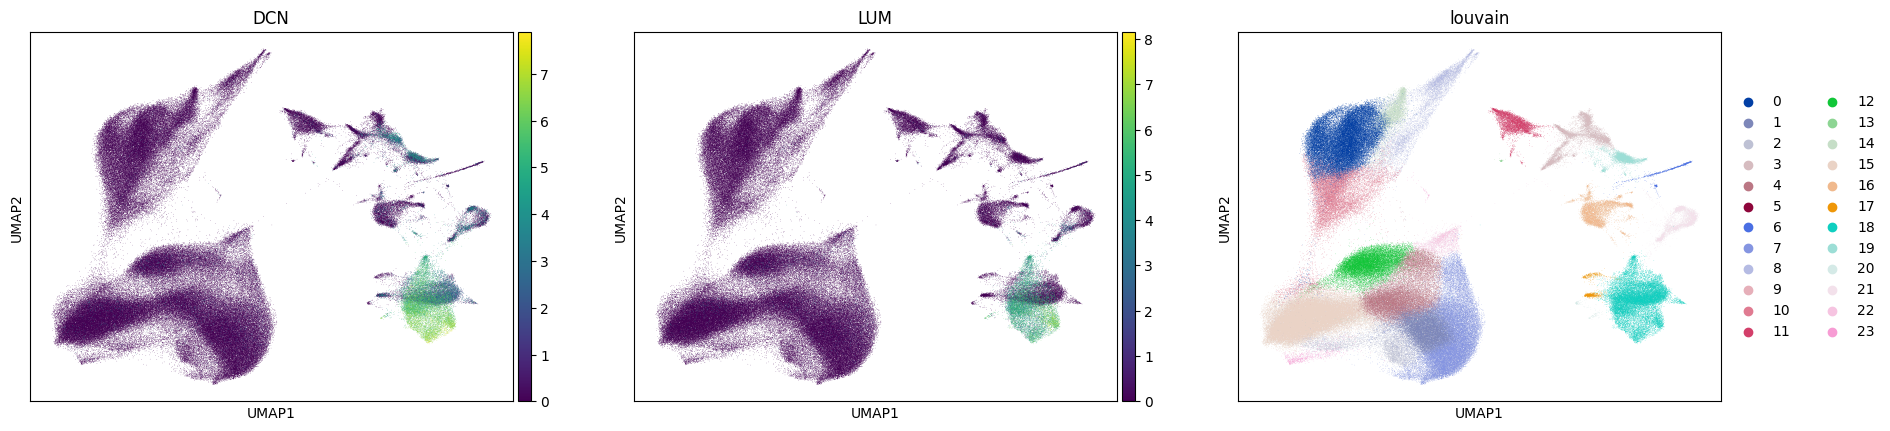

In [263]:
bioalpha.sc.pl.umap(adata, color=['DCN', 'LUM', 'louvain'])

In [268]:
np.nonzero(adata.raw.X.data > np.log1p(10000))

(array([  3075343,   3646067,   3646104, ..., 550107870, 550107911,
        550108120]),)

In [271]:
adata.raw.X.data.max()

16.166264

In [270]:
adata.raw.X.data[np.array([3075343,   3646067, 3646104])]

array([10.038372,  9.597452,  9.374759], dtype=float32)

In [266]:
adata.X.data

array([ 4.3432136,  2.8659415,  5.2798743, ..., 10.       , 10.       ,
       10.       ], dtype=float32)

In [304]:
batch_field_name, batch_metadata = get_sample_id_author_meta(1900)
adata.uns['log1p'] = {'base': None}
adata.obs[batch_field_name] = batch_metadata
bioalpha.sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
bioalpha.sc.pp.scale(adata, max_value=10)
bioalpha.sc.pp.pca(adata, n_comps=50)
bioalpha.sc.pp.harmony_integrate(adata, key=batch_field_name)

/data/sonvo/.local/lib/python3.10/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [306]:
bioalpha.sc.pp.neighbors(adata, n_neighbors=64, use_rep="X_pca_harmony")
bioalpha.sc.tl.umap(adata, n_components=2, use_rep="X_pca_harmony")
bioalpha.sc.tl.louvain(adata, resolution=0.8)

In [316]:
bioalpha.sc.tl.louvain(adata, resolution=1.5)

/data/sonvo/.local/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


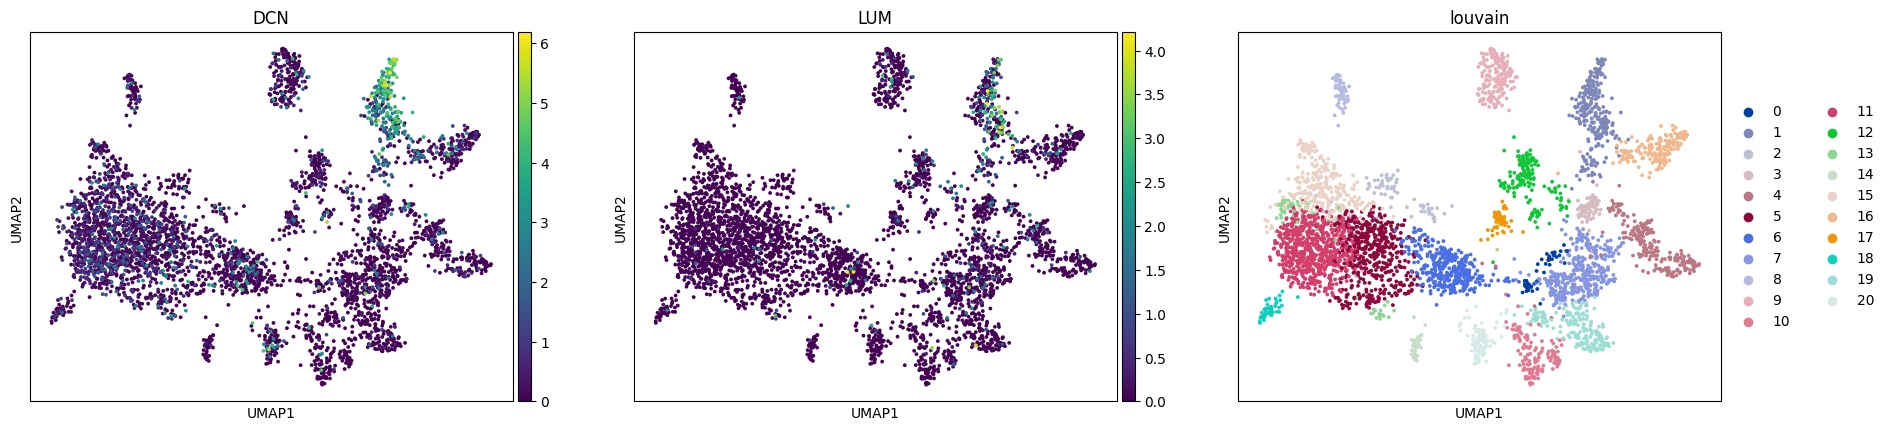

In [317]:
bioalpha.sc.pl.umap(adata, color=['DCN', 'LUM', 'louvain'])

In [60]:
adata = add_into_h5ad(2421)

2421 ---- have raw


In [61]:
batch_field_name, batch_metadata = get_sample_id_author_meta(2421)
adata.uns['log1p'] = {'base': None}
adata.obs[batch_field_name] = batch_metadata
bioalpha.sc.pp.highly_variable_genes(adata, n_top_genes=2000)
adata = adata[:, adata.var.highly_variable]
bioalpha.sc.pp.scale(adata, max_value=10)
bioalpha.sc.pp.pca(adata, n_comps=50)
bioalpha.sc.pp.harmony_integrate(adata, key=batch_field_name)

In [67]:
bioalpha.sc.pp.neighbors(adata, n_neighbors=64, use_rep="X_pca_harmony")
bioalpha.sc.tl.umap(adata, n_components=2, use_rep="X_pca_harmony")
bioalpha.sc.tl.louvain(adata, resolution=1.4)

In [65]:
celltype_arr = get_metadata_arr(2421, 'cell type - subgroup')

for child in SUB_FIBROBLAST_2_FIBROBLAST:
    celltype_arr[celltype_arr == child] = SUB_FIBROBLAST_2_FIBROBLAST[child]

adata.obs['ct'] = celltype_arr.astype('str')

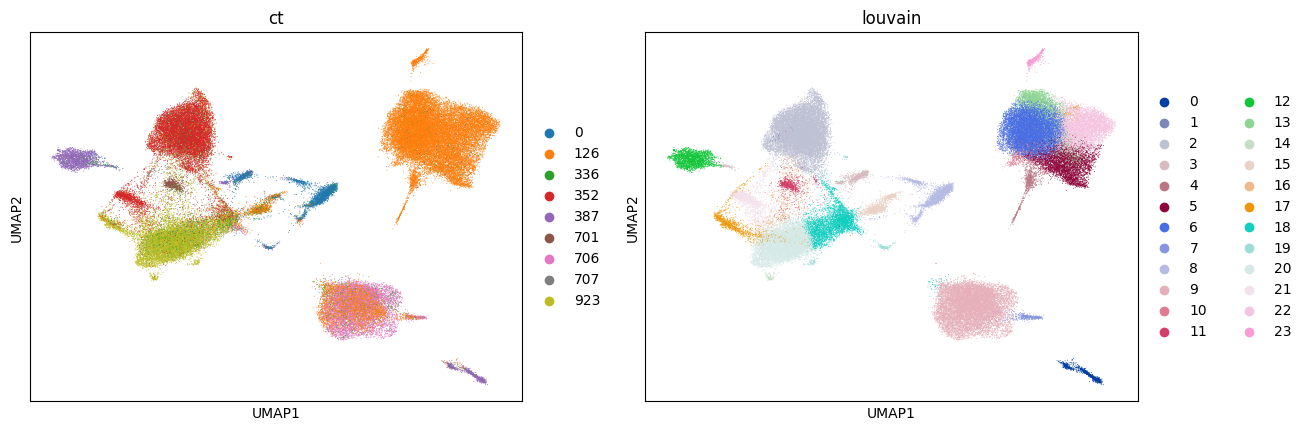

In [68]:
bioalpha.sc.pl.umap(adata, color=['ct', 'louvain'])

## ---------- End ----------------

In [26]:
df1 = pd.read_csv('F1_louvain.tsv', sep='\t', index_col=0)
df1.columns = ['F1_ori'] + df1.columns[1:].tolist()
df1 = df1['F1_ori']

df2 = pd.read_csv('F1_louvain_highly_vairable_genes.tsv', sep='\t', index_col=0)
df2.columns = ['F1_round1'] + df2.columns[1:].tolist()
df2 = df2['F1_round1']

df3 = pd.read_csv('F1_louvain_HVG_stable.tsv', sep='\t', index_col=0)
df3.columns = ['F1_latest'] + df3.columns[1:].tolist()
df3 = df3['F1_latest']

In [27]:
DF = pd.concat([df1, df2, df3], axis=1)

In [28]:
chosen_studies = DF[DF['F1_latest'] > 0.8].index.tolist()

In [29]:
chosen_studies

['E_MTAB_8581_Human_Thymus',
 'GSE132771_human',
 'E_MTAB_7407_FETAL_LIVER',
 'GSE107618',
 'GSE155698_PBMC',
 'PMID31892341_LUNG',
 'PMID31273297',
 'GSE147424',
 'SCP1038_HUMAN',
 'SCP498',
 'GSE171524',
 'SCP1265',
 'GSE178360',
 'GSE151302',
 'GSE165816',
 'GSE133747',
 'GSE161382',
 'GSE121893',
 'GSE184117',
 'GSE179565',
 'PMID33650774',
 'PMID32439707',
 'GSE162183',
 'GSE184111',
 'GSE184880',
 'GSE183837',
 'GSE186476_ALL',
 'SCP1884',
 'GSE159585',
 'SILETTI_ET_AL_2022_NONNEURON',
 'GSE158924',
 'GSE185100',
 'LAKEETAL',
 'GSE183904_FIG1',
 'GSE143704',
 'GSE206026',
 'GSE201586',
 'GSE226314',
 'GSE148073',
 'PMID_33212097']

In [30]:
df3_test = pd.read_csv('F1_louvain_HVG_stable.tsv', sep='\t', index_col=0)
df3_test.loc['GSE133747']

F1                                                               0.946359
cluster_resolution                                                    0.4
cluster_number                                                         10
5_F1                    [0.9448127421437795, 0.9455852506523147, 0.945...
5_cluster_resolution    [0.8, 0.6000000000000001, 0.7000000000000001, ...
5_cluster_number                                     [10, 10, 10, 12, 10]
Name: GSE133747, dtype: object

In [31]:
DF

,F1_ori,F1_round1,F1_latest
study_id,,,
E_MTAB_8581_Human_Thymus,0.675304,0.974017,0.973369
GSE132771_human,0.980584,0.968123,0.968123
E_MTAB_7407_FETAL_LIVER,0.930281,0.916828,0.916828
GSE107618,0.967752,0.890356,0.890356
GSE155698_PBMC,0.989603,0.946771,0.888424
PMID31892341_LUNG,0.942907,0.983250,0.981416
GSE128169,0.501217,0.337346,0.644446
PMID31273297,0.959327,0.971152,0.971257
GSE147424,0.996952,0.984886,0.984807


In [28]:
df3_test

,F1,cluster_resolution,cluster_number,5_F1,5_cluster_resolution,5_cluster_number
study_id,,,,,,
E_MTAB_8581_Human_Thymus,0.973617,1.2,17,"[0.6302632862167252, 0.6388561715269856, 0.972...","[1.0, 0.4, 1.4000000000000001, 1.3, 1.20000000...","[18, 19, 19, 19, 17]"
GSE132771_human,0.967917,0.1,7,"[0.916401842344879, 0.9208130038139013, 0.9303...","[0.5, 0.4, 0.30000000000000004, 0.2, 0.1]","[14, 14, 13, 11, 7]"
E_MTAB_7407_FETAL_LIVER,0.916828,0.1,0,"[0.9168277072560991, 0.9168277072560991, 0.916...","[0.5, 0.4, 0.30000000000000004, 0.2, 0.1]","[1, 1, 2, 1, 0]"
GSE107618,0.890356,1.0,7,"[0.8903561424569828, 0.8903561424569828, 0.890...","[1.4000000000000001, 1.2000000000000002, 0.9, ...","[7, 7, 3, 7, 7]"
GSE155698_PBMC,0.888424,0.5,4,"[0.8884239257538995, 0.8884239257538995, 0.888...","[0.4, 0.7000000000000001, 0.2, 0.3000000000000...","[3, 2, 4, 3, 4]"
PMID31892341_LUNG,0.981530,0.8,13,"[0.9813726012562001, 0.9813726012562001, 0.981...","[1.2000000000000002, 1.3, 1.1, 0.7000000000000...","[16, 16, 14, 11, 13]"
GSE128169,0.643754,0.5,7,"[0.6435232489382743, 0.6435232489382743, 0.643...","[0.2, 0.30000000000000004, 0.4, 0.600000000000...","[5, 4, 5, 9, 7]"
PMID31273297,0.970757,0.5,8,"[0.9705464006227205, 0.9705464006227205, 0.970...","[0.4, 0.30000000000000004, 0.6000000000000001,...","[8, 7, 12, 1, 8]"
GSE147424,0.984915,0.3,8,"[0.9608200345358258, 0.9610930315019661, 0.984...","[0.5, 0.4, 0.1, 0.2, 0.30000000000000004]","[10, 9, 6, 8, 8]"


In [34]:
all_trained_studies = [
    1629,
    1700,
    1714,
    1734,
    1783,
    1805,
    1848,
    1857,
    1891,
    1895,
    2140,
    2216,
    2252,
    2396,
    2397,
    2410,
    2423,
    2432,
    2507,
    2542,
    2615,
    2664,
    2719,
    2745,
    2793,
    2818,
    2836,
    2871,
    2872,
    2893,
    2900,
    2920,
    2969,
    2973,
    3047,
    3054,
    3090,
    3099,
    2421,
    2539,
]

In [39]:
import random

In [53]:
inferent_studies = random.sample(all_trained_studies, 8)
prediction_pool = {
    'trained_studies': [i for i in all_trained_studies if i not in inferent_studies],
    'inference_studies': inferent_studies
}

In [54]:
with open('ct_prediction_pool_5.json', 'w') as f:
    json.dump(prediction_pool, f)

In [56]:
json.loads(open('ct_prediction_pool_5.json').read())

{'trained_studies': [1700,
  1714,
  1734,
  1783,
  1805,
  1848,
  1857,
  1891,
  2216,
  2252,
  2396,
  2410,
  2423,
  2507,
  2542,
  2664,
  2719,
  2745,
  2818,
  2836,
  2871,
  2872,
  2893,
  2900,
  2920,
  2969,
  2973,
  3054,
  3090,
  3099,
  2421,
  2539],
 'inference_studies': [1629, 2615, 2793, 2397, 3047, 2140, 1895, 2432]}